# Working with Text Data in scikit-learn

## Agenda

1. Model building in scikit-learn (refresher)
2. Representing text as numerical data
3. Reading the SMS data
4. Vectorizing the SMS data
5. Building a Naive Bayes model
6. Comparing Naive Bayes with logistic regression
7. ***Post Hoc Interpretation***: Explain the logistic regression model using **SHAP**
9. Creating a DataFrame from individual text files

In [2]:
# for Python 2: use print only as a function
from __future__ import print_function

## Part 1: Model building in scikit-learn (refresher)

In [3]:
# load the iris dataset as an example
from sklearn.datasets import load_iris
iris = load_iris()

In [4]:
# store the feature matrix (X) and response vector (y)
X = iris.data
y = iris.target

In [5]:
print (X.shape, y.shape)

(150, 4) (150,)


**"Features"** are also known as predictors, inputs, or attributes. The **"response"** is also known as the target, label, or output.

In [6]:
# check the shapes of X and y
print(X.shape)
print(y.shape)

(150, 4)
(150,)


**"Observations"** are also known as samples, instances, or records.

In [7]:
# examine the first 5 rows of X (including the feature names)
import pandas as pd
pd.DataFrame(X, columns=iris.feature_names).head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2

In order to **build a model**, the features must be **numeric**, and every observation must have the **same features in the same order**.

In [8]:
# import the class
from sklearn.neighbors import KNeighborsClassifier

# instantiate the model (with the default parameters)
knn = KNeighborsClassifier()

# fit the model with data (occurs in-place)
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In order to make a **prediction**, the new observation must have the **same features as the training observations**, both in number and meaning.

In [9]:
# predict the response for a new observation
knn.predict([[3, 5, 4, 2]])

array([1])

## Part 2: Representing text as numerical data

In [10]:
# example text for model training (SMS messages)
simple_train = ['call you tonight', 'Call me a cab', 'please call me... PLEASE!']

From the [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction):

> Text Analysis is a major application field for machine learning algorithms. However the raw data, a sequence of symbols cannot be fed directly to the algorithms themselves as most of them expect **numerical feature vectors with a fixed size** rather than the **raw text documents with variable length**.

We will use [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to "convert text into a matrix of token counts":

In [11]:
# import and instantiate CountVectorizer (with the default parameters)
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [12]:
# learn the 'vocabulary' of the training data (occurs in-place)
vect.fit(simple_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [13]:
# examine the fitted vocabulary
vect.get_feature_names()

['cab', 'call', 'me', 'please', 'tonight', 'you']

In [14]:
# transform training data into a 'document-term matrix'
simple_train_dtm = vect.transform(simple_train)
simple_train_dtm

<3x6 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [15]:
# convert sparse matrix to a dense matrix
simple_train_dtm.toarray()

array([[0, 1, 0, 0, 1, 1],
       [1, 1, 1, 0, 0, 0],
       [0, 1, 1, 2, 0, 0]])

In [16]:
# examine the vocabulary and document-term matrix together
pd.DataFrame(simple_train_dtm.toarray(), columns=vect.get_feature_names())

cab  call  me  please  tonight  you
0    0     1   0       0        1    1
1    1     1   1       0        0    0
2    0     1   1       2        0    0

From the [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction):

> In this scheme, features and samples are defined as follows:

> - Each individual token occurrence frequency (normalized or not) is treated as a **feature**.
> - The vector of all the token frequencies for a given document is considered a multivariate **sample**.

> A **corpus of documents** can thus be represented by a matrix with **one row per document** and **one column per token** (e.g. word) occurring in the corpus.

> We call **vectorization** the general process of turning a collection of text documents into numerical feature vectors. This specific strategy (tokenization, counting and normalization) is called the **Bag of Words** or "Bag of n-grams" representation. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

In [17]:
# print the sparse matrix
print(simple_train_dtm)

  (0, 1)	1
  (0, 4)	1
  (0, 5)	1
  (1, 0)	1
  (1, 1)	1
  (1, 2)	1
  (2, 1)	1
  (2, 2)	1
  (2, 3)	2


From the [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction):

> As most documents will typically use a very small subset of the words used in the corpus, the resulting matrix will have **many feature values that are zeros** (typically more than 99% of them).

> For instance, a collection of 10,000 short text documents (such as emails) will use a vocabulary with a size in the order of 100,000 unique words in total while each document will use 100 to 1000 unique words individually.

> In order to be able to **store such a matrix in memory** but also to **speed up operations**, implementations will typically use a **sparse representation** such as the implementations available in the `scipy.sparse` package.

In [18]:
# example text for model testing
simple_test = ["please don't call me"]

In order to make a **prediction**, the new observation must have the **same features as the training observations**, both in number and meaning.

In [19]:
# transform testing data into a document-term matrix (using existing vocabulary)
simple_test_dtm = vect.transform(simple_test)
simple_test_dtm.toarray()

array([[0, 1, 1, 1, 0, 0]])

In [20]:
# examine the vocabulary and document-term matrix together
pd.DataFrame(simple_test_dtm.toarray(), columns=vect.get_feature_names())

cab  call  me  please  tonight  you
0    0     1   1       1        0    0

**Summary:**

- `vect.fit(train)` **learns the vocabulary** of the training data
- `vect.transform(train)` uses the **fitted vocabulary** to build a document-term matrix from the training data
- `vect.transform(test)` uses the **fitted vocabulary** to build a document-term matrix from the testing data (and **ignores tokens** it hasn't seen before)

## Part 3: Reading the SMS data

In [21]:
path = 'data//sms.tsv'
sms = pd.read_table(path, header=None, names=['label', 'message'])

In [22]:
# examine the shape
sms.shape

(5572, 2)

In [23]:
# examine the first 10 rows
sms.head(10)

label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
5  spam  FreeMsg Hey there darling it's been 3 week's n...
6   ham  Even my brother is not like to speak with me. ...
7   ham  As per your request 'Melle Melle (Oru Minnamin...
8  spam  WINNER!! As a valued network customer you have...
9  spam  Had your mobile 11 months or more? U R entitle...

In [24]:
# examine the class distribution
sms.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [25]:
# convert label to a numerical variable
sms['label_num'] = sms.label.map({'ham':0, 'spam':1})

In [26]:
# check that the conversion worked
sms.head(10)

label                                            message  label_num
0   ham  Go until jurong point, crazy.. Available only ...          0
1   ham                      Ok lar... Joking wif u oni...          0
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...          1
3   ham  U dun say so early hor... U c already then say...          0
4   ham  Nah I don't think he goes to usf, he lives aro...          0
5  spam  FreeMsg Hey there darling it's been 3 week's n...          1
6   ham  Even my brother is not like to speak with me. ...          0
7   ham  As per your request 'Melle Melle (Oru Minnamin...          0
8  spam  WINNER!! As a valued network customer you have...          1
9  spam  Had your mobile 11 months or more? U R entitle...          1

In [27]:
# usual way to define X and y (from the iris data) for use with a MODEL
X = iris.data
y = iris.target
print(X.shape)
print(y.shape)

(150, 4)
(150,)


In [28]:
# required way to define X and y for use with COUNTVECTORIZER
X = sms.message
y = sms.label_num
print(X.shape)
print(y.shape)

(5572,)
(5572,)


In [29]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(X_test.shape)

(4179,)
(1393,)


## Part 4: Vectorizing the SMS data

In [30]:
# instantiate the vectorizer
vect = CountVectorizer()

In [31]:
# learn training data vocabulary, then use it to create a document-term matrix
vect.fit(X_train)
X_train_dtm = vect.transform(X_train)

In [32]:
# alternative: combine fit and transform into a single step
X_train_dtm = vect.fit_transform(X_train)

In [33]:
# examine the document-term matrix
X_train_dtm

<4179x7456 sparse matrix of type '<class 'numpy.int64'>'
	with 55209 stored elements in Compressed Sparse Row format>

In [34]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<1393x7456 sparse matrix of type '<class 'numpy.int64'>'
	with 17604 stored elements in Compressed Sparse Row format>

## Part 5: Building a Naive Bayes model

We will use [multinomial Naive Bayes](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html):

> The multinomial Naive Bayes classifier is suitable for classification with **discrete features** (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

In [35]:
# import and instantiate a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [36]:
# train the model using X_train_dtm (timing it with an IPython "magic command")
%time nb.fit(X_train_dtm, y_train)

CPU times: user 4.69 ms, sys: 1.71 ms, total: 6.4 ms
Wall time: 7.04 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [37]:
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

In [38]:
# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.9885139985642498

In [39]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)

array([[1203,    5],
       [  11,  174]])

In [40]:
# print message text for the false positives (meaning they were incorrectly classified as spam)
X_test[y_test < y_pred_class]

574               Waiting for your call.
3375             Also andros ice etc etc
45      No calls..messages..missed calls
3415             No pic. Please re-send.
1988    No calls..messages..missed calls
Name: message, dtype: object

In [41]:
# print message text for the false negatives (meaning they were incorrectly classified as ham)
X_test[y_test > y_pred_class]

3132    LookAtMe!: Thanks for your purchase of a video...
5       FreeMsg Hey there darling it's been 3 week's n...
3530    Xmas & New Years Eve tickets are now on sale f...
684     Hi I'm sue. I am 20 years old and work as a la...
1875    Would you like to see my XXX pics they are so ...
1893    CALL 09090900040 & LISTEN TO EXTREME DIRTY LIV...
4298    thesmszone.com lets you send free anonymous an...
4949    Hi this is Amy, we will be sending you a free ...
2821    INTERFLORA - It's not too late to order Inter...
2247    Hi ya babe x u 4goten bout me?' scammers getti...
4514    Money i have won wining number 946 wot do i do...
Name: message, dtype: object

In [42]:
# what do you notice about the false negatives?
X_test[3132]

"LookAtMe!: Thanks for your purchase of a video clip from LookAtMe!, you've been charged 35p. Think you can do better? Why not send a video in a MMSto 32323."

In [43]:
X_test[5]

"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv"

In [44]:
X_train[y_train==1].sample(10)

2575    Your next amazing xxx PICSFREE1 video will be ...
1544    Hello from Orange. For 1 month's free access t...
4821    Check Out Choose Your Babe Videos @ sms.shsex....
1269    Can U get 2 phone NOW? I wanna chat 2 set up m...
2642    You are guaranteed the latest Nokia Phone, a 4...
2708    Great NEW Offer - DOUBLE Mins & DOUBLE Txt on ...
385     Double mins and txts 4 6months FREE Bluetooth ...
4249    accordingly. I repeat, just text the word ok o...
240     U 447801259231 have a secret admirer who is lo...
2053    Call 09094100151 to use ur mins! Calls cast 10...
Name: message, dtype: object

In [45]:
X_train[2871]

'YOUR CHANCE TO BE ON A REALITY FANTASY SHOW call now = 08707509020 Just 20p per min NTT Ltd, PO Box 1327 Croydon CR9 5WB 0870 is a national = rate call.'

In [46]:
# calculate predicted probabilities for X_test_dtm (poorly calibrated)
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([2.87744864e-03, 1.83488846e-05, 2.07301295e-03, ...,
       1.09026171e-06, 1.00000000e+00, 3.98279868e-09])

In [47]:
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.9866431000536962

## Part 6: Comparing Naive Bayes with logistic regression

We will compare multinomial Naive Bayes with [logistic regression](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression):

> Logistic regression, despite its name, is a **linear model for classification** rather than regression. Logistic regression is also known in the literature as logit regression, maximum-entropy classification (MaxEnt) or the log-linear classifier. In this model, the probabilities describing the possible outcomes of a single trial are modeled using a logistic function.

In [48]:
# import and instantiate a logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [49]:
# train the model using X_train_dtm
%time logreg.fit(X_train_dtm, y_train)

CPU times: user 28.5 ms, sys: 3.29 ms, total: 31.7 ms
Wall time: 37 ms


/Users/rui/pyenv/bt5153/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [50]:
# make class predictions for X_test_dtm
y_pred_class = logreg.predict(X_test_dtm)

In [51]:
# calculate predicted probabilities for X_test_dtm (well calibrated)
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([0.01269556, 0.00347183, 0.00616517, ..., 0.03354907, 0.99725053,
       0.00157706])

In [52]:
# calculate accuracy
metrics.accuracy_score(y_test, y_pred_class)

0.9877961234745154

In [53]:
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.9936817612314301

### How to explain the feature importance of Naive Bayes in this task, i.e., the spamminess of each token

Hints: you may refer to these two attributes: **nb.feature_count_** and **nb.class_count_**

It is the intrinsic explanation of machine learning models

## Part 7: Explain linear regression model using SHAP

1. Explain the prediction of an instance x by computing the contribution of each feature to the prediction

2. SHAP compute Shapley values to quantify the contribution

3. Therefore, each feature value in each instance has a Shapley values.

4. How to understand the Shapley values?  It can be thought as ``forces`` that either increases or decreases the prediction

In [115]:
import shap #pip install shap which requires tqdm version >= 4.29.1 (pip install tqdm==4.29.1)
shap.initjs()

In [120]:
explainer = shap.LinearExplainer(logreg, X_train_dtm, feature_dependence="independent")

In [121]:
print(type(X_test_dtm))

<class 'scipy.sparse.csr.csr_matrix'>


In [122]:
shap_values = explainer.shap_values(X_test_dtm)
X_test_array = X_test_dtm.toarray() # we need to pass a dense version for the plotting functions

#### Explain one "spam" sample's prediction 

1. The baseline for Shapley values is the average of all predictions. 
2. In the plot, each Shapley value is an arrow that pushes to increase (positive value) or decrease (negative value) the prediction. 
3. These forces balance each other out at the actual prediction of the data instance.

In [123]:
ind = 16
print(y_test.iloc[ind])
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test_array[ind,:],
    feature_names=vect.get_feature_names()
)

1


#### Explain one "non-spam" sample's prediction 

In [124]:
ind = 10
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test_array[ind,:],
    feature_names=vect.get_feature_names()
)

##### Summary Plot
Each point on the summary plot is a Shapley value for a feature and an instance. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value. The color represents the value of the feature from low to high. Overlapping points are jittered in y-axis direction, so we get a sense of the distribution of the Shapley values per feature. The features are ordered according to their importance.

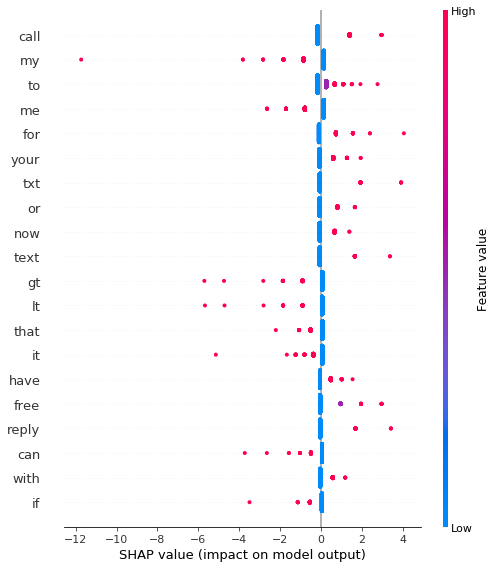

In [125]:
shap.summary_plot(shap_values, X_test_array, feature_names=vect.get_feature_names())

We can also take the mean absolute value of the SHAP values for each feature to get a standard bar plot 

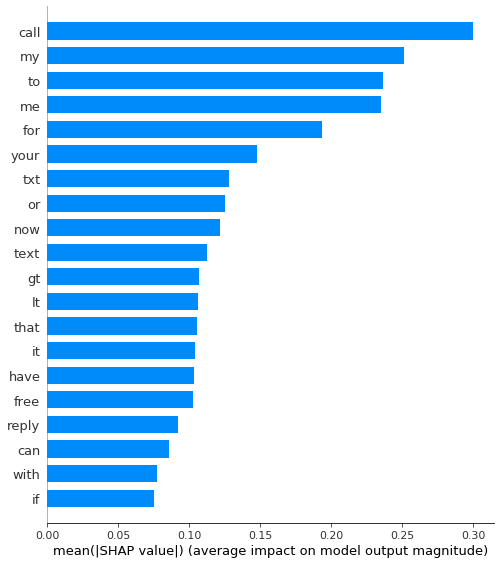

In [126]:
shap.summary_plot(shap_values, X_test_array, feature_names=vect.get_feature_names(), sort=True, plot_type="bar")
# the word "call" is the most important features, changing the predicted spam probability on average by 0.28

## Part 8: Creating a DataFrame from individual text files

In [133]:
# use glob to create a list of ham filenames
import glob
ham_filenames = glob.glob('data/ham_files/*.txt')
ham_filenames

['data/ham_files/email1.txt',
 'data/ham_files/email3.txt',
 'data/ham_files/email5.txt']

In [134]:
# read the contents of the ham files into a list (each list element is one email)
ham_text = []
for filename in ham_filenames:
    with open(filename) as f:
        ham_text.append(f.read())
ham_text

['This is a ham email.\nIt has 2 lines.\n',
 'This is another ham email.\n',
 'This is yet another ham email.\n']

In [135]:
# repeat this process for the spam files
spam_filenames = glob.glob('data/spam_files/*.txt')
spam_text = []
for filename in spam_filenames:
    with open(filename) as f:
        spam_text.append(f.read())
spam_text

['This is a spam email.\n', 'This is another spam email.\n']

In [136]:
# combine the ham and spam lists
all_text = ham_text + spam_text
all_text

['This is a ham email.\nIt has 2 lines.\n',
 'This is another ham email.\n',
 'This is yet another ham email.\n',
 'This is a spam email.\n',
 'This is another spam email.\n']

In [137]:
# create a list of labels (ham=0, spam=1)
all_labels = [0]*len(ham_text) + [1]*len(spam_text)
all_labels

[0, 0, 0, 1, 1]

In [138]:
# convert the lists into a DataFrame
pd.DataFrame({'label':all_labels, 'message':all_text})

label                                  message
0      0  This is a ham email.\nIt has 2 lines.\n
1      0             This is another ham email.\n
2      0         This is yet another ham email.\n
3      1                  This is a spam email.\n
4      1            This is another spam email.\n